<a href="https://colab.research.google.com/github/tskmr/MIP/blob/main/Lec9(2025_6_16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データ

In [1]:
t = c(0.073, 0.098, 0.117, 0.135, 0.175, 0.262, 0.27, 0.35, 0.386, 0.456)

# 累積分布関数$F_T(t)$のノンパラメトリック推定

累積分布関数$F_T(t)$のノンパラメトリック推定値を，$\hat p = \frac{i-0.5}{n}$で求める．

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95

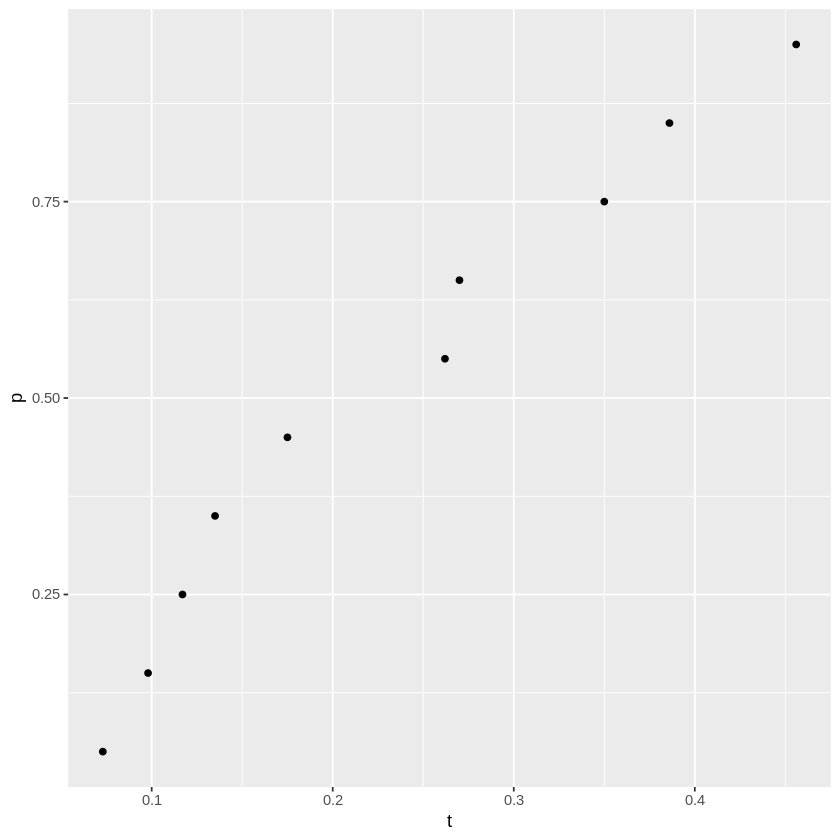

In [2]:
n = length(t)
i = seq_along(t)
p = (i-.5)/n
d = data.frame(t, n, i, p)
library(tidyverse)
d %>% ggplot() + geom_point(aes(t, p))
p

# 確率プロットによる分布の特定

位置尺度族から，正規分布・最小極値分布・最大極値分布・ロジスティック分布のクォンタイルを準備

In [3]:
PhiInv_norm = function(p){ qnorm(p) }
PhiInv_sev = function(p){ log(-log(1-p)) }
PhiInv_lev = function(p){ -log(-log(p)) }
PhiInv_logis = function(p){ log(p/(1-p)) }

位置尺度族の確率プロット

In [4]:
pN = data.frame(x = t, y = PhiInv_norm(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("Normal")
pS = data.frame(x = t, y = PhiInv_sev(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("SEV")
pL = data.frame(x = t, y = PhiInv_lev(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("LEV")
pLogis = data.frame(x = t, y = PhiInv_logis(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("Logistic")

対数位置尺度族の確率プロット（対数正規分布・ワイブル分布・フレシェ分布・対数ロジスティック分布）

In [5]:
pLN = data.frame(x = log(t), y = PhiInv_norm(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("Log-normal")
pW = data.frame(x = log(t), y = PhiInv_sev(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("Weibull")
pF = data.frame(x = log(t), y = PhiInv_lev(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("Frechet")
pLL = data.frame(x = log(t), y = PhiInv_logis(p)) %>%
  ggplot() + geom_point(aes(x, y)) + ggtitle("Log-logistic")

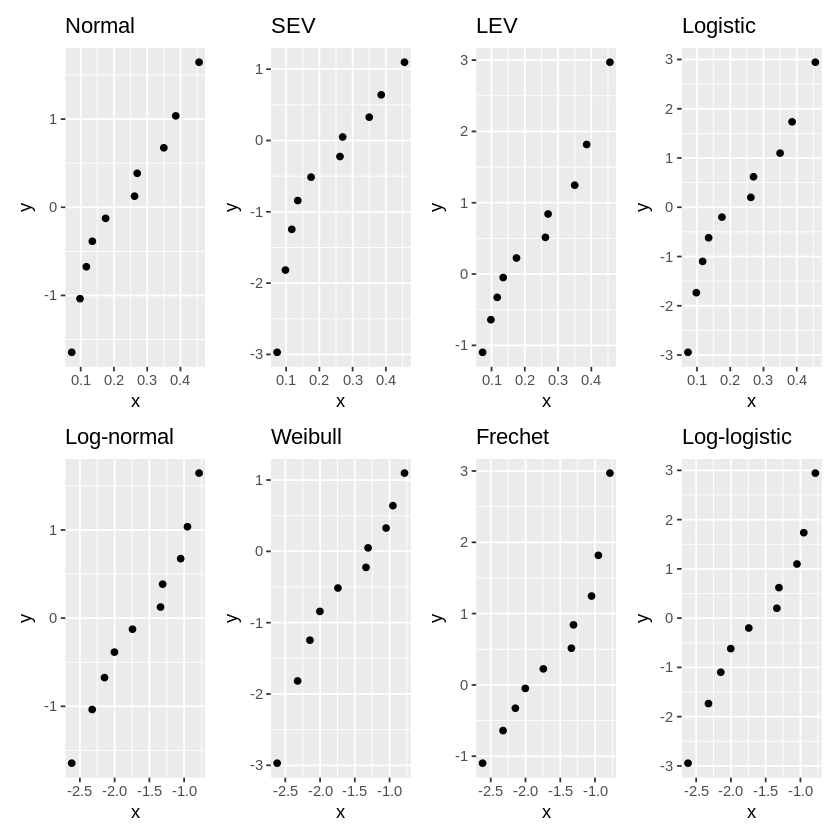

In [13]:
if(!require(patchwork)) install.packages("patchwork")
library(patchwork)
wrap_plots(pN, pS, pL, pLogis, pLN, pW, pF, pLL, ncol=4)

対数正規分布か，ワイブル分布か，LEVもあり．McCoolの提案するワイブル分布は，ある程度妥当であると言える．

# 最尤推定

対数尤度関数の定義

In [14]:
dsev = function(z){ # 標準最小極値分布の密度関数
  exp(z-exp(z))
}

psev = function(z){ # 標準最小極値分布の分布関数
  1-exp(-exp(z))
}

ft = function(x, par){ # ワイブル分布の密度関数
  mu = par[1]
  sigma = par[2]
  1/x/sigma * dsev((log(x) - mu)/sigma)
}

Ft = function(x, par){ # ワイブル分布の分布関数
  mu = par[1]
  sigma = par[2]
  psev((log(x) - mu)/sigma)
}

l_i = function(x, par, n_d, n_r){ # 1標本の対数尤度関数
  n_d * log(ft(x, par)) + n_r * log(1-Ft(x, par))
}

loglikelihood = function(x, n_d, n_r){ # すべての標本の対数尤度関数
  function(par){
    sum(l_i(x, par, n_d, n_r))
  }
}

対数尤度関数にデータを入れる

In [15]:
dj = c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1) # 故障点のフラグ
rj = dj - 1 # 右打切りのフラグ．今回はすべて0.
dj; rj
l = loglikelihood(t, dj, rj) # 対数尤度関数にデータを渡す
l(c(-0.5, 1)) # 計算チェック

[1] 1 1 1 1 1 1 1 1 1 1

[1] 0 0 0 0 0 0 0 0 0 0

[1] 1.171669

対数尤度関数の最大化により，最尤推定値を求める

In [18]:
# 最尤推定．初期値を mu= 1, sigma = 1とした．
res = optim(par = c(1, 1), fn = l, control= list(fnscale = -1), hessian = TRUE)
res

Warning message in log(ft(x, par)):
“NaNs produced”


-38.54367,-16.46593
-16.46593,-67.42751


In [19]:
# 最尤推定値を変数に保存
mu = res$par[1]
sigma = res$par[2]

得られた最尤推定値が，データをうまく表せているのかを確認するために，ノンパラメトリック推定の結果と重ねてみる．

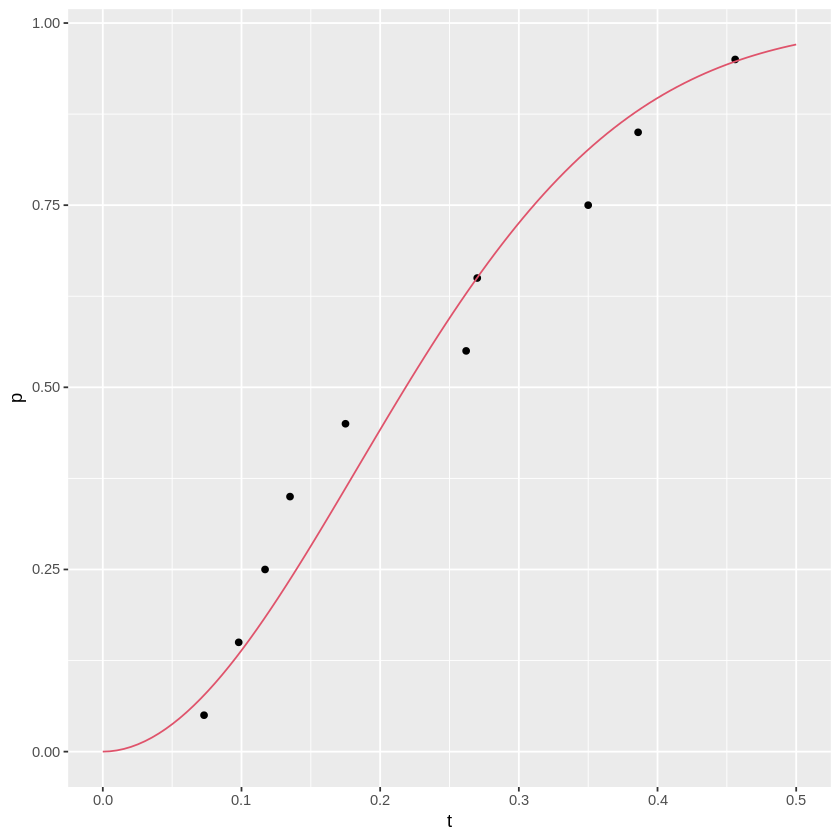

In [34]:
# 累積分布関数の計算
tt = seq(0, .5, len=100)
yy = Ft(tt, par = c(mu, sigma))
dd = data.frame(tt, yy)
d %>% ggplot() +
  geom_point(aes(t, p)) +
  geom_line(data=dd, aes(tt, yy), col=2)

同じく，データをうまく表せているのかを確認するために，確率プロットに重ねる．

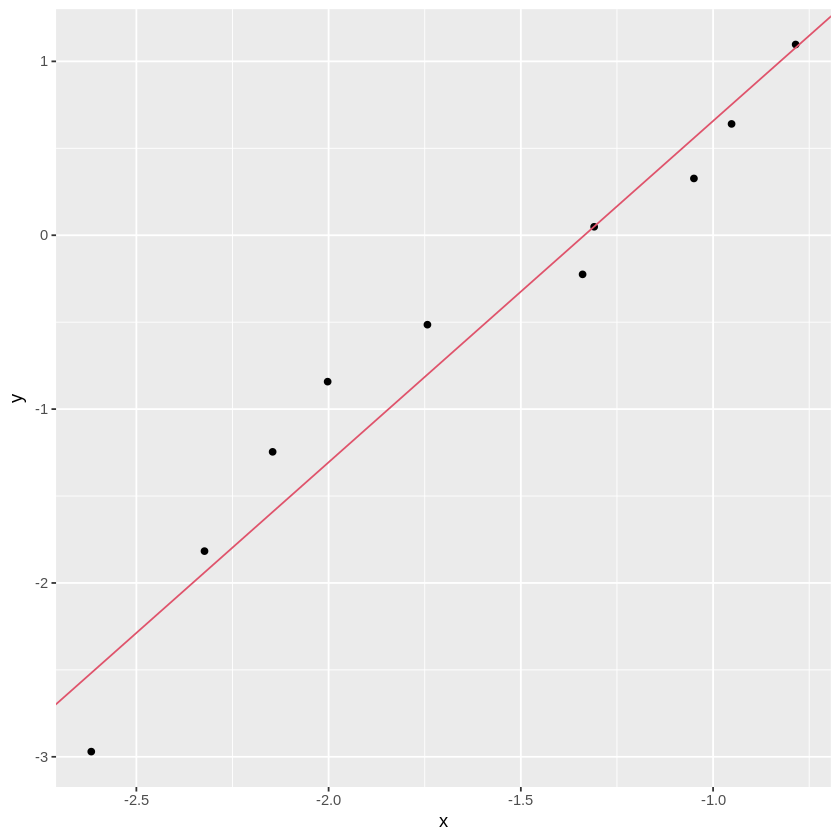

In [21]:
# 最尤推定値 mu, sigmaから，確率プロットの傾きと切片を計算
slope = 1/sigma
interception = -mu/sigma
data.frame(x = log(t), y = PhiInv_sev(p)) %>%
  ggplot() + geom_point(aes(x, y)) +
  geom_abline( slope = slope,  intercept=interception, col=2)

また，同じくデータにうまく合っているのかを確認するために，データのヒストグラムと推定したワイブル分布のパラメータによる密度関数を重ねてみる．

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


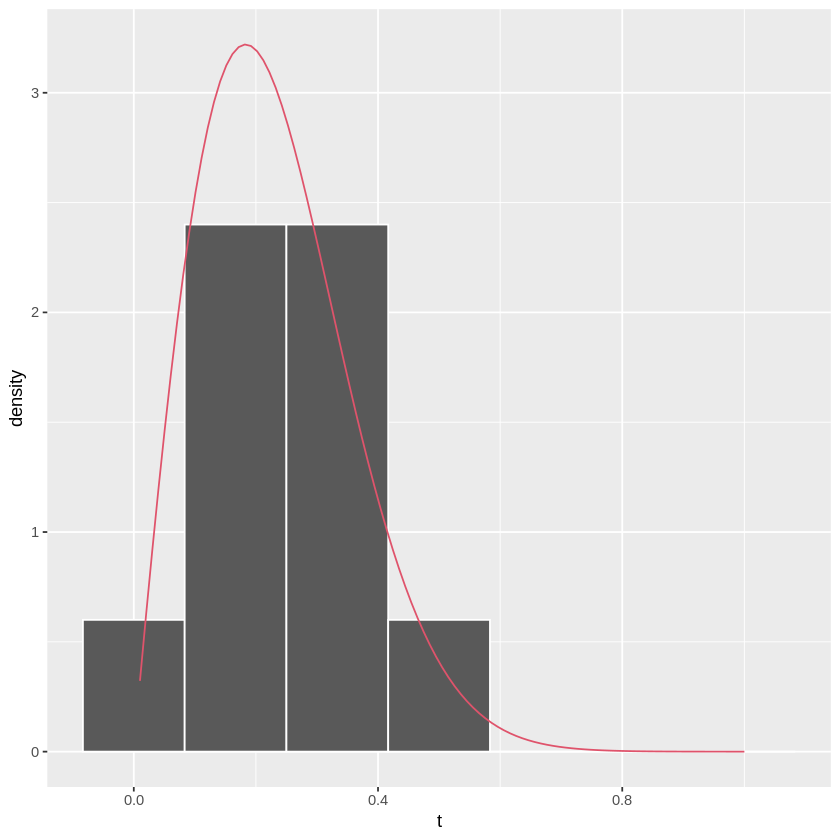

In [25]:
# 密度関数の計算
tt = seq(0, 1, len=100)
yy = ft(tt, par = c(mu, sigma))
dd = data.frame(tt, yy)
dd %>% ggplot()+
  geom_histogram(data = d, aes(t, ..density..), bins = 7, col="white")+
  geom_line(aes(tt, yy), col=2)

# 最尤推定による区間推定

In [35]:
Hn = res$hessian
I = -Hn
(aVar = solve(I))
(aVar.mu = diag(aVar)[1])
(aVar.sigma = diag(aVar)[2])

0.028966484,-0.007073671
-0.007073671,0.016558147


[1] 0.02896648

[1] 0.01655815

In [52]:
ci.mu = c(mu - qnorm(0.975) * sqrt(aVar.mu), mu + qnorm(0.975) * sqrt(aVar.mu))
ci.mu

[1] -1.668405 -1.001251

In [51]:
ci.sigma = c(sigma - qnorm(0.975) * sqrt(aVar.sigma), sigma + qnorm(0.975) * sqrt(aVar.sigma))
ci.sigma

[1] 0.2571708 0.7615811

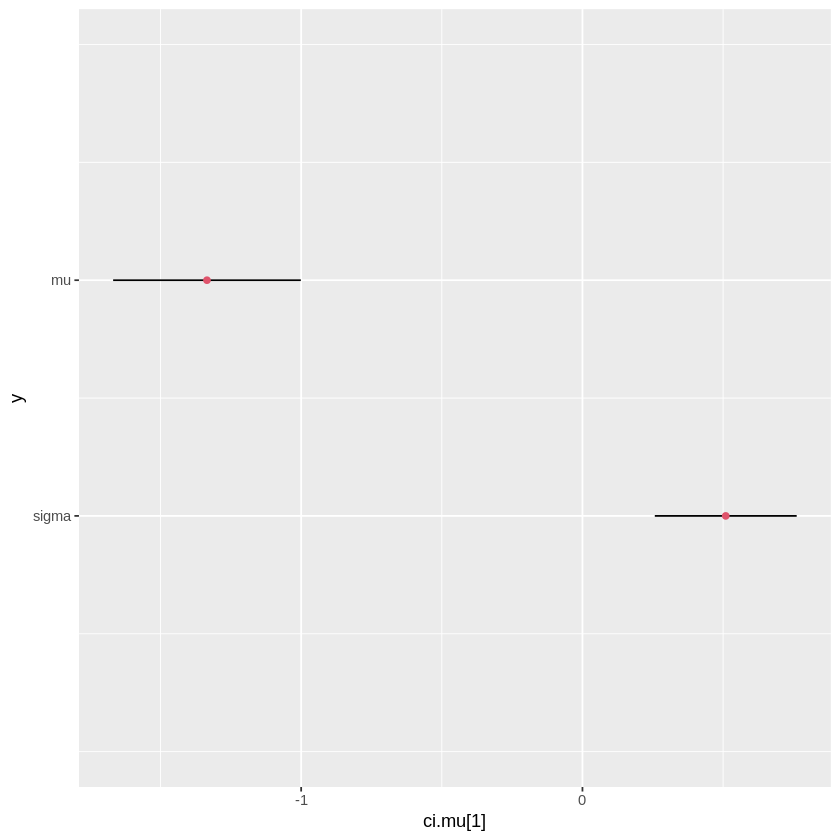

In [50]:
ggplot() + geom_segment(data=NULL, aes(x = ci.mu[1], xend=ci.mu[2], y=2)) + geom_point(data=NULL, aes(x = mu, y=2), col=2)+
  geom_segment(data=NULL, aes(x = ci.sigma[1], xend=ci.sigma[2], y=1)) + geom_point(data=NULL, aes(x = sigma, y=1), col=2) +
    scale_y_continuous(limits = c(0, 3), labels = c("mu", "sigma"), breaks = c(2, 1))

# 累積分布関数の区間推定

まず，ヤコビ行列を求めるが，楽するために数値微分を用いることを考える．
試しに，正しく微分して求めた Jacobian1 と，数値微分で楽した Jacobian2 を比較する．高精度に計算できていることが分かる．よって，Jacobian2 を用いる．

In [78]:
Jacobian1 = function(t, mu, sigma){
  j1 = -1/sigma * dsev((log(t)-mu)/sigma)
  j2 = -(log(t)-mu)/sigma^2 * dsev((log(t)-mu)/sigma)
  matrix(c(j1, j2), ncol=2)
}
Jacobian2 = function(t, mu, sigma, h = 0.00001){
  j1 = (Ft(t, c(mu+h, sigma)) - Ft(t, c(mu-h, sigma)))/(2*h)
  j2 = (Ft(t, c(mu, sigma+h)) - Ft(t, c(mu, sigma-h)))/(2*h)
  matrix(c(j1, j2), ncol=2)
}
Jacobian1(1, 10, 3)
Jacobian2(1, 10, 3)

-0.0114746,0.03824866


-0.0114746,0.03824866


累積分布関数の漸近分散を求める．

In [80]:
t = seq(0, 0.5, len=100)
hat.F = Ft(t, c(mu, sigma))
Jacobian = function(t, mu, sigma, h = 0.00001){
  j1 = (Ft(t, c(mu-h, sigma)) - Ft(t, c(mu+h, sigma)))/(2*h)
  j2 = (Ft(t, c(mu, sigma-h)) - Ft(t, c(mu, sigma+h)))/(2*h)
  matrix(c(j1, j2), ncol=2)
}
J = Jacobian(t, mu, sigma)
tJ = t(J)
var.F = sapply(1:length(t), function(i) J[i,]%*%aVar%*%tJ[,i])
var.F

[1] 0.000000e+00 7.935905e-07 8.451799e-06 3.257472e-05 8.308002e-05
  [6] 1.691522e-04 2.987468e-04 4.783287e-04 7.127444e-04 1.005181e-03
 [11] 1.357188e-03 1.768746e-03 2.238374e-03 2.763260e-03 3.339413e-03
 [16] 3.961830e-03 4.624669e-03 5.321429e-03 6.045128e-03 6.788469e-03
 [21] 7.544011e-03 8.304319e-03 9.062107e-03 9.810358e-03 1.054244e-02
 [26] 1.125220e-02 1.193402e-02 1.258291e-02 1.319450e-02 1.376513e-02
 [31] 1.429178e-02 1.477215e-02 1.520455e-02 1.558797e-02 1.592195e-02
 [36] 1.620661e-02 1.644256e-02 1.663083e-02 1.677284e-02 1.687036e-02
 [41] 1.692540e-02 1.694016e-02 1.691702e-02 1.685845e-02 1.676697e-02
 [46] 1.664510e-02 1.649534e-02 1.632013e-02 1.612182e-02 1.590266e-02
 [51] 1.566475e-02 1.541008e-02 1.514049e-02 1.485766e-02 1.456315e-02
 [56] 1.425838e-02 1.394461e-02 1.362301e-02 1.329462e-02 1.296039e-02
 [61] 1.262117e-02 1.227776e-02 1.193088e-02 1.158119e-02 1.122933e-02
 [66] 1.087590e-02 1.052149e-02 1.016666e-02 9.811965e-03 9.457973e-03
 [71] 9.105235e-03 8.754311e-03 8.405761e-03 8.060145e-03 7.718027e-03
 [76] 7.379966e-03 7.046515e-03 6.718220e-03 6.395613e-03 6.079209e-03
 [81] 5.769502e-03 5.466960e-03 5.172024e-03 4.885097e-03 4.606552e-03
 [86] 4.336718e-03 4.075885e-03 3.824299e-03 3.582161e-03 3.349627e-03
 [91] 3.126807e-03 2.913768e-03 2.710530e-03 2.517072e-03 2.333331e-03
 [96] 2.159205e-03 1.994555e-03 1.839210e-03 1.692966e-03 1.555592e-03

累積分布関数の区間推定を行う．

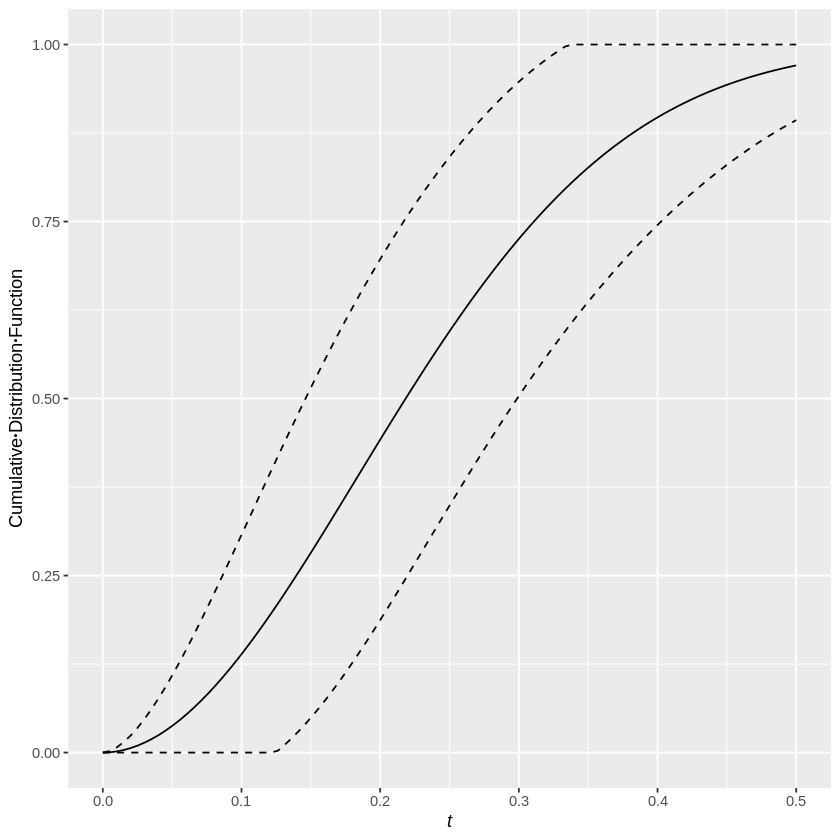

In [81]:
dFT = data.frame(
  t,
  mean=hat.F,
  upper=hat.F+qnorm(0.975)*sqrt(var.F),
  lower=hat.F-qnorm(0.975)*sqrt(var.F))
dFT = dFT %>% mutate(upper = ifelse(upper>1, 1, upper), lower=ifelse(lower<0, 0, lower))
plot = dFT %>%
  ggplot()+geom_line(aes(t, mean))+
  geom_line(aes(t, upper), linetype=2)+
  geom_line(aes(t, lower), linetype=2)+
  xlab(bquote(italic(t)))+ylab("Cumulative␣Distribution␣Function")
plot